In [8]:
import numpy as np
import nibabel as nib
import glob

In [9]:
file_list = glob.glob("./data/*.nii")
file_list.sort()
for file_name in file_list:
    print(file_name)

./data/epcase01_PET_MAC_20181001110741_4.nii
./data/epcase02_PET_MAC_20180913151013_5.nii
./data/epcase03_PET_MAC_20181016124202_4.nii
./data/mri_inv.nii
./data/subj01_t1bravo.nii


In [10]:
file_nii = nib.load(file_list[-2])
file_data = file_nii.get_fdata()
file_header = file_nii.header
file_affine = file_nii.affine

In [11]:
file_affine

array([[ 4.68643039e-01,  6.79624267e-04, -1.55013436e-02,
        -1.14535881e+02],
       [ 1.27209831e-04,  4.67762709e-01,  3.98881808e-02,
        -7.23637543e+01],
       [ 1.21310456e-02, -3.11612394e-02,  5.98425090e-01,
        -8.59880753e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [12]:
print(file_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 284   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.46880004 0.4688     0.5999533  1.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.03326011
quatern_c       : -0.012936838
quatern_d       : -0.00029477736
qoffset_x       : -114.53588

In [13]:
spacing = file_header["pixdim"][1:4]
print(spacing)

[0.46880004 0.4688     0.5999533 ]


In [14]:
dim = file_header["dim"][1:4]
print(dim)

[512 512 284]


In [15]:
phy_space = spacing * dim
print(phy_space)

[240.02562 240.0256  170.38673]


In [16]:
phy_space/89

array([2.696917 , 2.6969168, 1.9144577], dtype=float32)

## zoom

In [18]:
from scipy.ndimage import zoom
new_array = zoom(file_data, (0.5, 0.5, 0.3133))

/Users/convez/.conda/envs/pytorch/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [19]:
print(new_array.shape)

(256, 256, 89)


In [25]:
import copy
new_header = copy.deepcopy(file_header)
new_header["pixdim"][1] = file_header["pixdim"][1]*2
new_header["pixdim"][2] = file_header["pixdim"][2]*2
new_header["pixdim"][3] = file_header["pixdim"][3]/0.3133
print(new_header["pixdim"])

[1.        0.9376001 0.9376    1.9149482 1.        0.        0.
 0.       ]


In [27]:
import numpy as np
sino_file = nib.Nifti1Image(new_array, affine=file_affine, header=new_header)
nib.save(sino_file, "./mri_89.nii")

## Affine

In [17]:
from scipy.ndimage import affine_transform as apply_affine

affine_matrix = file_affine[:3, :3]
print(affine_matrix)

affine_offset = file_affine[:3, -1]
print(affine_offset)

[[ 4.68643039e-01  6.79624267e-04 -1.55013436e-02]
 [ 1.27209831e-04  4.67762709e-01  3.98881808e-02]
 [ 1.21310456e-02 -3.11612394e-02  5.98425090e-01]]
[-114.53588104  -72.36375427  -85.98807526]


In [28]:
affine_data = apply_affine(file_data, affine_matrix, offset=affine_offset)

In [29]:
new_affine = np.zeros((4,4))
new_affine[-1, -1] = 1
print(new_affine)

import copy

new_header = copy.deepcopy(file_header)
new_header["srow_x"] = np.zeros((1,4))
new_header["srow_y"] = np.zeros((1,4))
new_header["srow_z"] = np.zeros((1,4))
print(new_header["srow_x"])
print(new_header["srow_y"])
print(new_header["srow_z"])

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]


In [34]:
affine_file = nib.Nifti1Image(affine_data, file_affine, file_header)
nib.save(affine_file, "./affined.nii")

In [35]:
inv_matrix = np.linalg.inv(file_affine[:3, :3])
print(inv_matrix)

inv_offset = -file_affine[:3, -1]
print(inv_offset)

[[-0.85333333 -0.         -0.        ]
 [ 0.          0.85333333  0.        ]
 [ 0.          0.          0.35971239]]
[-149.4140625  129.4140625  114.9598999]


In [36]:
inv_data = apply_affine(file_data, inv_matrix, offset=inv_offset)

In [37]:
inv_file = nib.Nifti1Image(inv_data, file_affine, file_header)
nib.save(inv_file, "./inv_affined.nii")

In [33]:
from PIL import Image       
resized_image = numpy.array(Image.fromarray(original_image).resize(newsize))

NameError: name 'numpy' is not defined

In [34]:
print(file_data.shape)

(512, 512, 284)


In [36]:
img = file_data[256, :, :]
print(img.shape)

(512, 284)


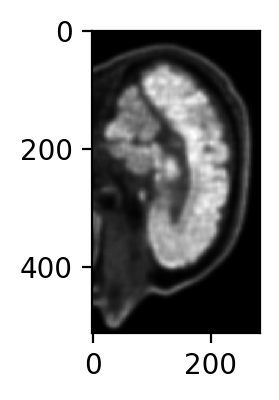

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize = (2,2), dpi=200)
plt.imshow(img, cmap='gray')

In [44]:
re_img = np.array(Image.fromarray(img).resize((89, 512)))

(512, 89)


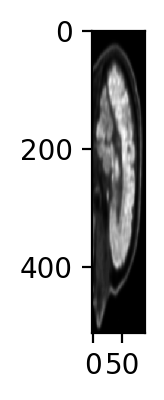

In [45]:
import matplotlib.pyplot as plt
print(re_img.shape)
plt.figure(figsize = (2,2), dpi=200)
plt.imshow(re_img, cmap='gray')

In [47]:
from scipy.io import savemat
mdic = {"data": file_data}
savemat("brain_1_pet.mat", mdic)

In [49]:
import os
print(os.path.basename(file_name)[:-4])

subj03_pet
